<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/QRS_detection/QRS_detection_CNN%2BLSTM_100sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

Streaming output truncated to the last 5000 lines.
Length: 5468 (5.3K) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.atr’

physionet.org/files 100%[===================>]   5.34K  --.-KB/s    in 0s      

2025-02-09 21:24:25 (2.03 GB/s) - ‘physionet.org/files/mitdb/1.0.0/223.atr’ saved [5468/5468]

--2025-02-09 21:24:25--  https://physionet.org/files/mitdb/1.0.0/223.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1950000 (1.9M) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.dat’

physionet.org/files 100%[===================>]   1.86M   688KB/s    in 2.8s    

2025-02-09 21:24:28 (688 KB/s) - ‘physionet.org/files/mitdb/1.0.0/223.dat’ saved [1950000/1950000]

--2025-02-09 21:24:28--  https://physionet.org/files/mitdb/1.0.0/223.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 258 [text/plain]
Saving to: ‘physionet.

In [2]:
!pip install wfdb numpy scipy matplotlib scikit-learn tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 86.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


# 2- Load an ECG Record and Its Annotations

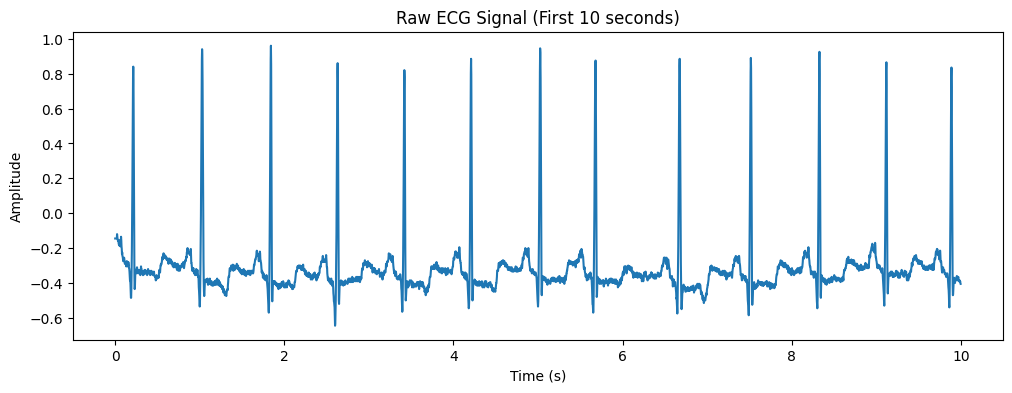

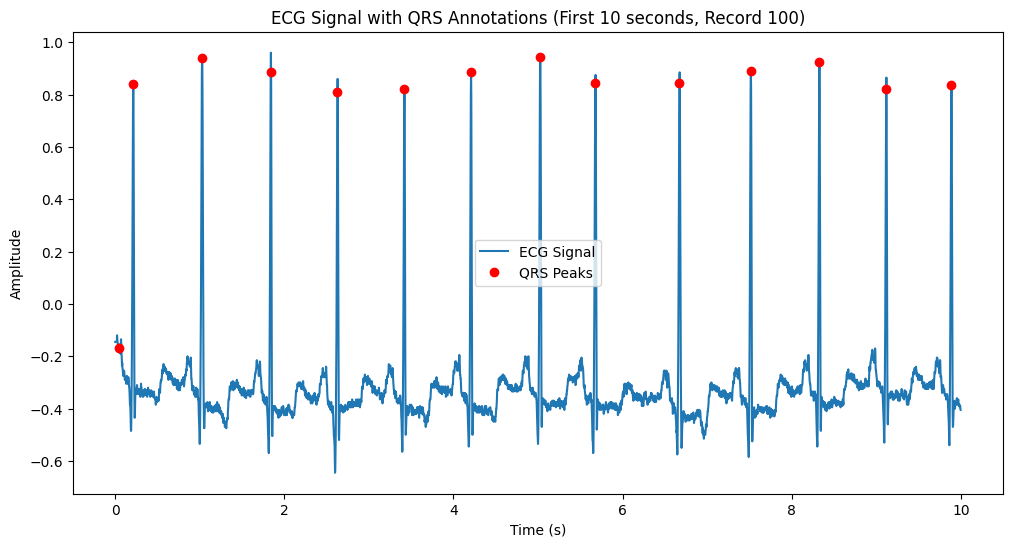

In [3]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np

# Replace '100' with the record number you want to load
record_dir = '/content/physionet.org/files/mitdb/1.0.0/'
record_name = '100'
record_name = record_dir + record_name
record = wfdb.rdrecord(record_name)
annotation = wfdb.rdann(record_name, 'atr')

# Use channel 0 (if multi-channel) and get the sampling frequency (typically 360 Hz)
ecg_signal = record.p_signal[:, 0]
fs = record.fs

# Define time axis
time_axis = [i / fs for i in range(len(ecg_signal))]

# Plot the first 10 seconds of the raw ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:fs*10], ecg_signal[:fs*10])
plt.title("Raw ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot ECG with QRS annotations (also limited to the first 10s)
plt.figure(figsize=(12, 6))
plt.plot(time_axis[:fs*10], ecg_signal[:fs*10], label="ECG Signal")

# Filter QRS annotations within the first 10s
qrs_indices_10s = annotation.sample[annotation.sample < fs*10]
qrs_values_10s = record.p_signal[qrs_indices_10s, 0]

# Plot QRS peaks
time_axis = np.array(time_axis)  # Convert to NumPy array
plt.plot(time_axis[qrs_indices_10s], qrs_values_10s, 'ro', label='QRS Peaks')


plt.title("ECG Signal with QRS Annotations (First 10 seconds, Record 100)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


# 3- Preprocess the Signal

## A. Filtering

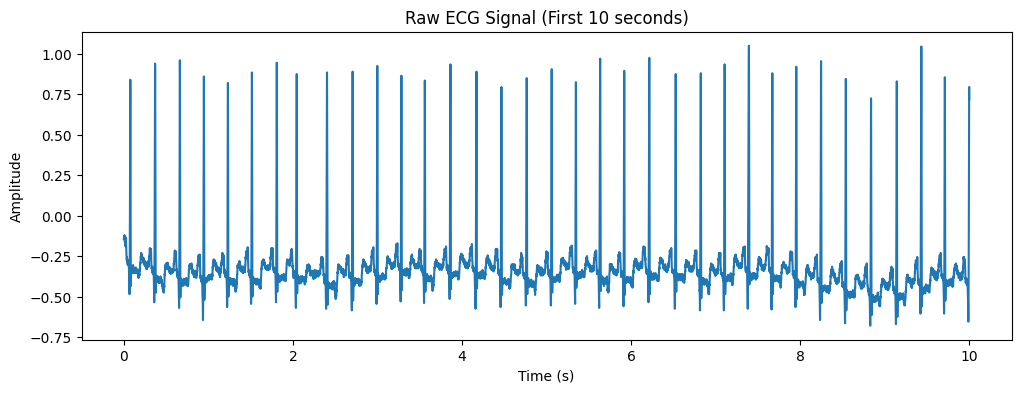

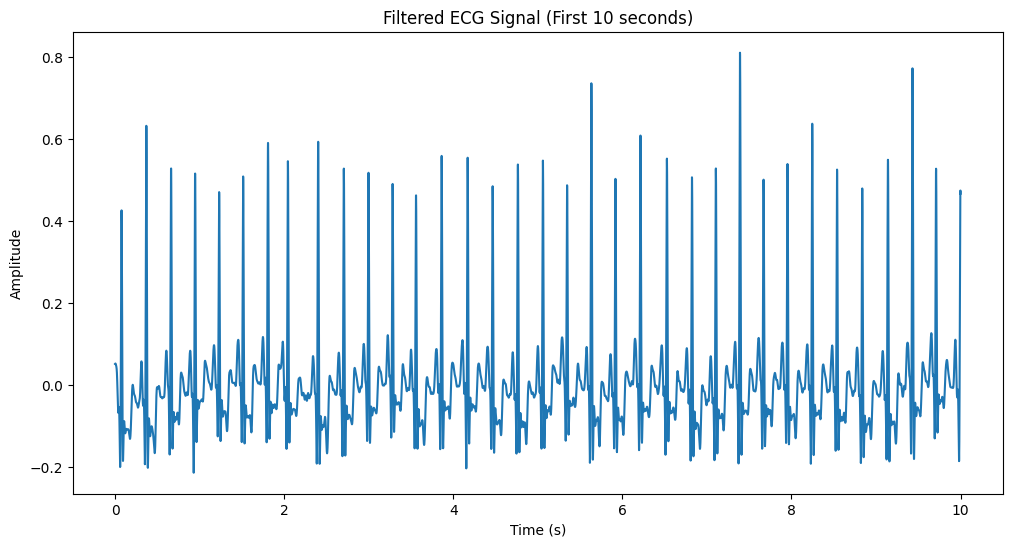

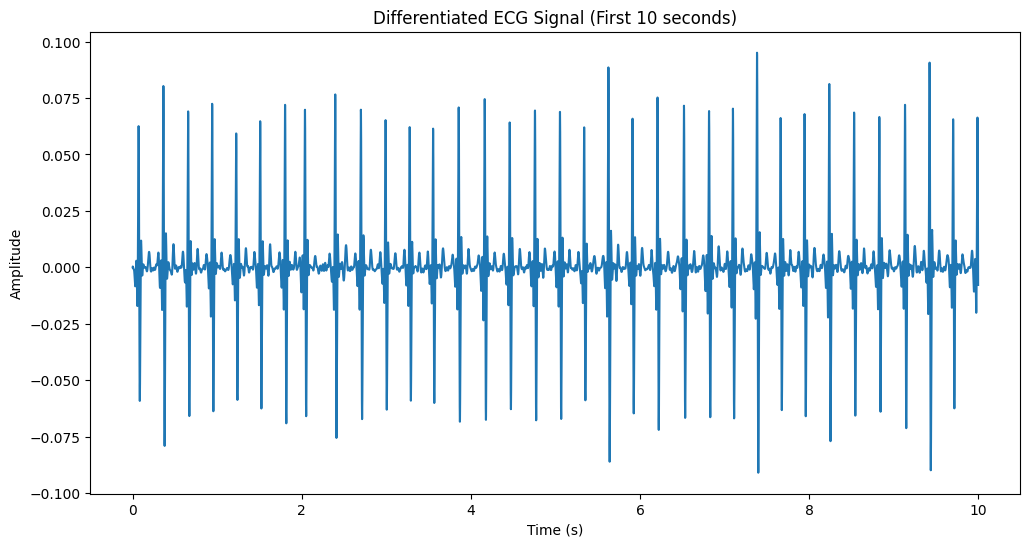

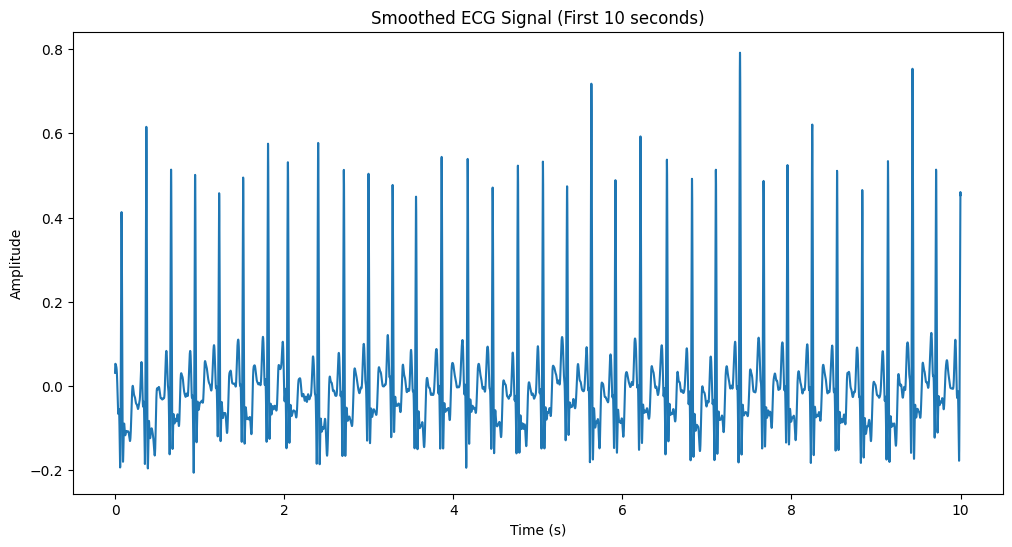

In [4]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def bandpass_filter(data, fs, lowcut=0.5, highcut=40.0, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered = signal.filtfilt(b, a, data)
    return filtered

def differentiate_signal(data, fs):
    # Differentiate the signal using a first-order difference
    differentiated = np.diff(data, prepend=data[0])
    return differentiated

def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed

# Example usage
fs = 1000  # Sampling frequency in Hz
time_axis = np.arange(0, len(ecg_signal)) / fs  # Time axis in seconds

# Apply bandpass filter
filtered_signal = bandpass_filter(ecg_signal, fs)

# Optionally differentiate the signal
differentiated_signal = differentiate_signal(filtered_signal, fs)

# Optionally smooth the signal
smoothed_signal = smooth_signal(filtered_signal, window_size=5)

# Plot the first 10 seconds of the raw ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:fs*10], ecg_signal[:fs*10])
plt.title("Raw ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot filtered signal
plt.figure(figsize=(12, 6))
plt.plot(time_axis[:fs*10], filtered_signal[:fs*10])
plt.title("Filtered ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot differentiated signal (optional)
plt.figure(figsize=(12, 6))
plt.plot(time_axis[:fs*10], differentiated_signal[:fs*10])
plt.title("Differentiated ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot smoothed signal (optional)
plt.figure(figsize=(12, 6))
plt.plot(time_axis[:fs*10], smoothed_signal[:fs*10])
plt.title("Smoothed ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

## B. Normalization

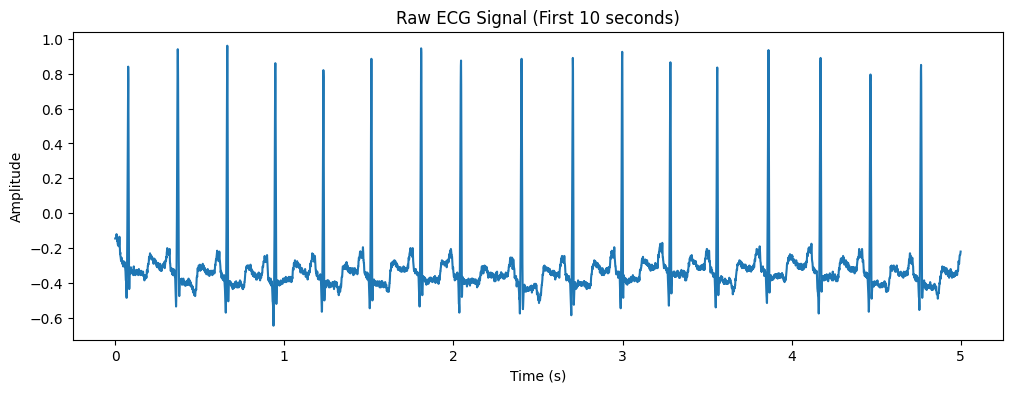

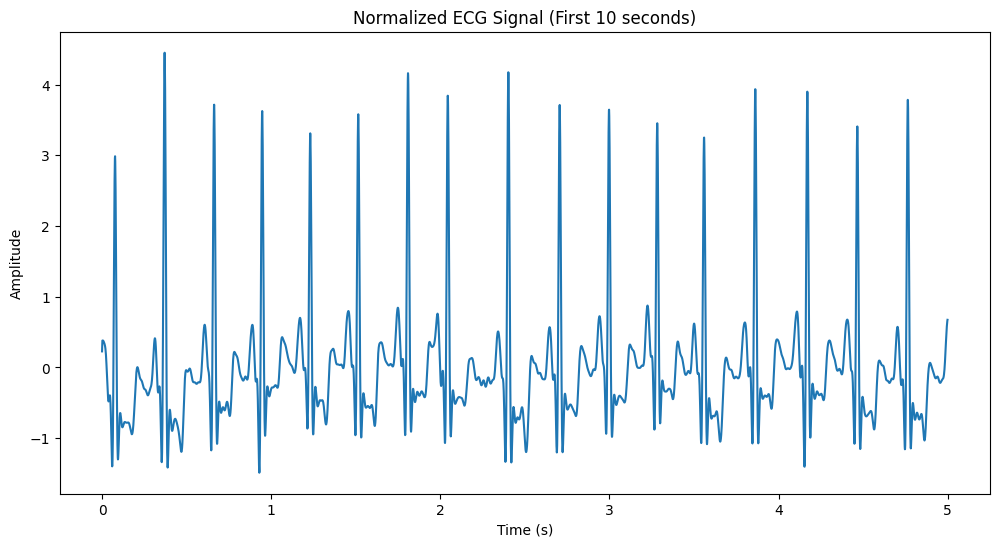

In [5]:
def normalize_signal(data):
    """
    Normalize the signal using z-score normalization.
    """
    return (data - np.mean(data)) / np.std(data)

# Normalize the smoothed signal
normalized_signal = normalize_signal(smoothed_signal)

# Plot the first 10 seconds of the raw ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:fs*5], ecg_signal[:fs*5])
plt.title("Raw ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot the normalized signal
plt.figure(figsize=(12, 6))
plt.plot(time_axis[:fs*5], normalized_signal[:fs*5])
plt.title("Normalized ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# 4- Segment the Signal for QRS Detection

In [6]:
import numpy as np

def segment_signal(signal, window_size=100, overlap=50):
    """
    Segment the signal into fixed-length windows with a specified overlap.

    Args:
        signal (np.array): The input signal.
        window_size (int): Length of each segment (in samples).
        overlap (int): Number of overlapping samples between consecutive segments.

    Returns:
        np.array: Array of segmented windows.
    """
    segments = []
    step = window_size - overlap  # Step size for sliding window
    for start in range(0, len(signal) - window_size + 1, step):
        end = start + window_size
        segments.append(signal[start:end])
    return np.array(segments)

# Example usage
window_size = 100  # Fixed window size (e.g., 250 samples)
overlap = 50      # Overlap between windows (e.g., 50% overlap)

# Segment the normalized signal
segmented_signal = segment_signal(normalized_signal, window_size=window_size, overlap=overlap)

print(f"Extracted {len(segmented_signal)} segments with window size {window_size} and {overlap} samples overlap.")

Extracted 12999 segments with window size 100 and 50 samples overlap.


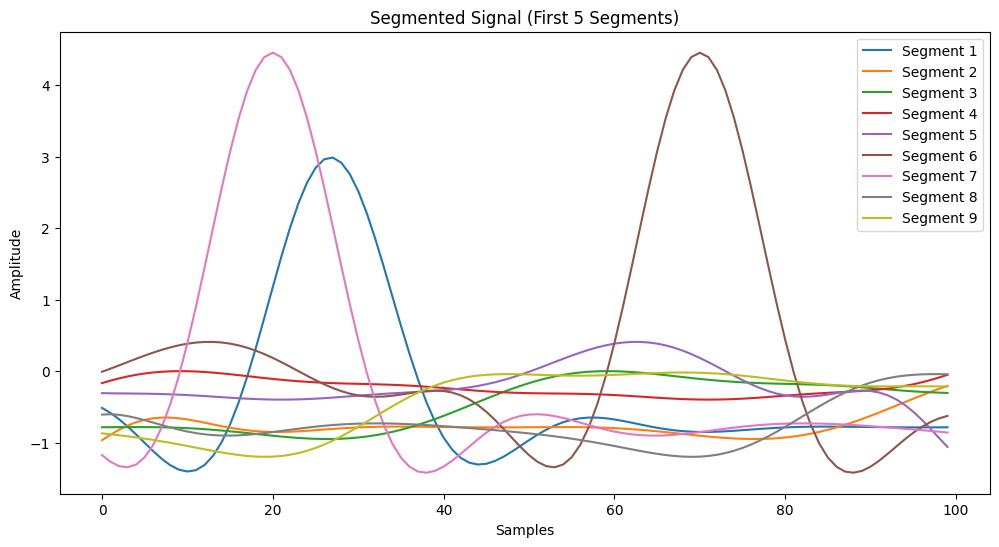

In [7]:
# Plot the first few segments
plt.figure(figsize=(12, 6))
for i, segment in enumerate(segmented_signal[1:10]):  # Plot first 5 segments
    plt.plot(segment, label=f"Segment {i+1}")
plt.title("Segmented Signal (First 5 Segments)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# 5- Prepare the Dataset for the CNN + LSTM Model

## A. Labeling and Combining the Data

In [8]:
import numpy as np

def label_segments(segments, qrs_indices, window_size=100, overlap=50):
    """
    Label each segment as QRS (1) or non-QRS (0), ensuring an equal number of 0 and 1 labels.

    Args:
        segments (np.array): Array of segmented windows.
        qrs_indices (list): List of QRS indices (in samples).
        window_size (int): Length of each segment (in samples).
        overlap (int): Number of overlapping samples between consecutive segments.

    Returns:
        np.array: Array of labels (1 for QRS, 0 for non-QRS).
    """
    labels = np.zeros(len(segments), dtype=int)
    step = window_size - overlap  # Step size for sliding window

    # Label QRS segments
    for i, segment_start in enumerate(range(0, len(normalized_signal) - window_size + 1, step)):
        segment_end = segment_start + window_size
        # Check if any QRS index falls within this segment
        for qrs in qrs_indices:
            if segment_start <= qrs < segment_end:
                labels[i] = 1
                break

    # Balance the dataset by randomly sampling non-QRS segments
    qrs_count = np.sum(labels == 1)  # Number of QRS segments
    non_qrs_indices = np.where(labels == 0)[0]  # Indices of non-QRS segments

    # Randomly sample non-QRS segments to match the number of QRS segments
    if len(non_qrs_indices) > qrs_count:
        sampled_non_qrs_indices = np.random.choice(non_qrs_indices, size=qrs_count, replace=False)
        labels[sampled_non_qrs_indices] = 0  # Ensure sampled non-QRS segments are labeled as 0
    else:
        print("Warning: Not enough non-QRS segments to balance the dataset.")

    return labels
# Filter the annotation symbols to include only typical QRS types (adjust as needed)
qrs_symbols = ['N', 'L', 'R', 'V', 'A']  # Common QRS annotation symbols
qrs_indices = [s for s, sym in zip(annotation.sample, annotation.symbol) if sym in qrs_symbols]

# Label the segments
segment_labels = label_segments(segmented_signal, qrs_indices, window_size=100, overlap=50)
print(f"Segment labels: {segment_labels}")


print(f"Balanced labels: {segment_labels}")
print(f"Number of QRS segments: {np.sum(segment_labels == 1)}")
print(f"Number of non-QRS segments: {np.sum(segment_labels == 0)}")

Segment labels: [1 1 0 ... 0 0 1]
Balanced labels: [1 1 0 ... 0 0 1]
Number of QRS segments: 4545
Number of non-QRS segments: 8454


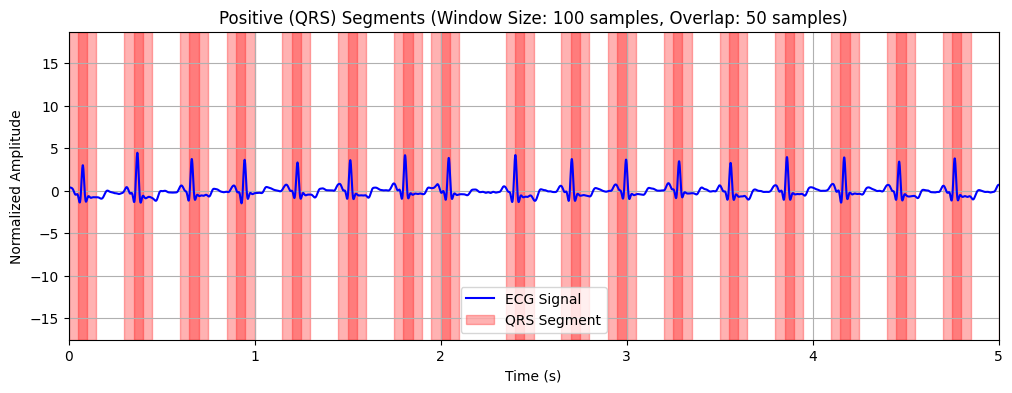

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


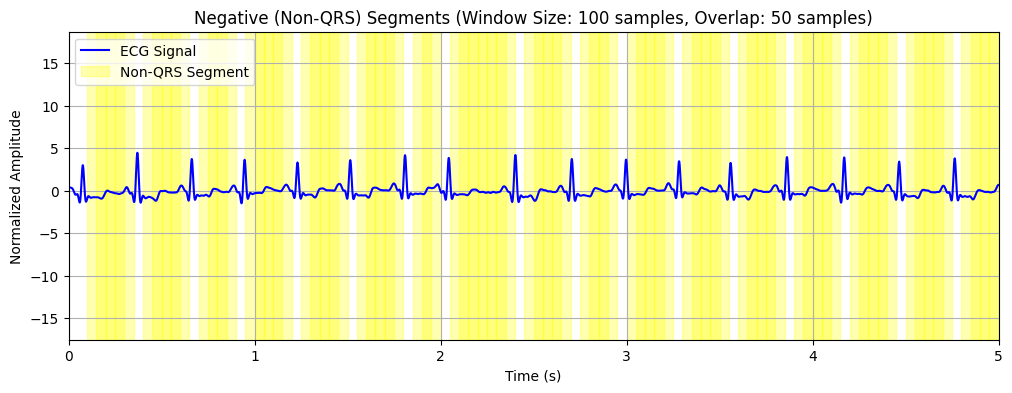

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define fixed-length window parameters
window_size = 100  # Fixed window size (e.g., 250 samples)
overlap = 50      # Overlap between windows (e.g., 50% overlap)
half_window = window_size // 2  # Half window size

# Segment the signal into fixed-length windows
segmented_signal = segment_signal(normalized_signal, window_size=window_size, overlap=overlap)

# Label the segments as QRS (1) or non-QRS (0)
segment_labels = label_segments(segmented_signal, qrs_indices, window_size=window_size, overlap=overlap)

# Convert segment indices to start and end times (in seconds)
segment_windows = []
step = window_size - overlap  # Step size for sliding window
for i, start in enumerate(range(0, len(normalized_signal) - window_size + 1, step)):
    end = start + window_size
    segment_windows.append((start / fs, end / fs))  # Convert to seconds

# Separate positive (QRS) and negative (non-QRS) windows
positive_windows = [segment_windows[i] for i, label in enumerate(segment_labels) if label == 1]
negative_windows = [segment_windows[i] for i, label in enumerate(segment_labels) if label == 0]

# Define zoom window (e.g., from 0 to 5 seconds)
zoom_start = 0  # Start time in seconds
zoom_end = 5    # End time in seconds

# Plot 1: Positive (QRS) Segments
plt.figure(figsize=(12, 4))
plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

# Highlight positive (QRS) windows in red
for start, end in positive_windows:
    plt.axvspan(start, end, color="red", alpha=0.3, label="QRS Segment" if start == positive_windows[0][0] else "")

plt.title(f"Positive (QRS) Segments (Window Size: {window_size} samples, Overlap: {overlap} samples)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.xlim(zoom_start, zoom_end)  # Zoom in on the time range
plt.legend()
plt.grid()
plt.show()

# Plot 2: Negative (Non-QRS) Segments
plt.figure(figsize=(12, 4))
plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

# Highlight negative (non-QRS) windows in yellow
for start, end in negative_windows:
    plt.axvspan(start, end, color="yellow", alpha=0.3, label="Non-QRS Segment" if start == negative_windows[0][0] else "")

plt.title(f"Negative (Non-QRS) Segments (Window Size: {window_size} samples, Overlap: {overlap} samples)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.xlim(zoom_start, zoom_end)  # Zoom in on the time range
plt.legend()
plt.grid()
plt.show()

In [10]:
print("Number of positive (QRS) segments:", len(positive_windows))
print("Number of negative (non-QRS) segments:", len(negative_windows))

Number of positive (QRS) segments: 4545
Number of negative (non-QRS) segments: 8454


## B. Shuffle and Reshape Data

In [11]:
from sklearn.utils import shuffle
import numpy as np

# Shuffle the data
all_segments, all_labels = shuffle(segmented_signal, segment_labels, random_state=42)

# Reshape to (num_samples, window_length, 1)
all_segments = all_segments.reshape(all_segments.shape[0], all_segments.shape[1], 1)
print("Reshaped data for CNN+LSTM:", all_segments.shape)

# Ensure all_labels is a 1D array
all_labels = np.array(all_labels).flatten()  # Convert to 1D array if it's not already
print("Shape of all_labels:", all_labels.shape)

# Separate positive and negative segments
positive_segments = all_segments[all_labels == 1]  # Index using the 1D boolean array
negative_segments = all_segments[all_labels == 0]

# Undersample the majority class (negative segments)
num_positive = len(positive_segments)
negative_segments_balanced = negative_segments[:num_positive]  # Take the same number as positive segments

# Combine balanced positive and negative segments
balanced_segments = np.concatenate([positive_segments, negative_segments_balanced])
balanced_labels = np.concatenate([np.ones(num_positive), np.zeros(num_positive)])  # Labels: 1 for QRS, 0 for non-QRS

# Shuffle the balanced dataset
balanced_segments, balanced_labels = shuffle(balanced_segments, balanced_labels, random_state=42)

# Reshape to (num_samples, window_length, 1)
balanced_segments = balanced_segments.reshape(balanced_segments.shape[0], balanced_segments.shape[1], 1)
print("Balanced data shape:", balanced_segments.shape)

Reshaped data for CNN+LSTM: (12999, 100, 1)
Shape of all_labels: (12999,)
Balanced data shape: (9090, 100, 1)


## C. Split

In [12]:
from sklearn.model_selection import train_test_split

# Split into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(balanced_segments, balanced_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (5454, 100, 1) (5454,)
Validation: (1818, 100, 1) (1818,)
Test: (1818, 100, 1) (1818,)


In [13]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train: (5454, 100, 1)
Shape of y_train: (5454,)


In [14]:
# Reshape y_train, y_val, and y_test to match the model's output shape
y_train = y_train.reshape(-1, 1, 1)  # Shape: [num_samples, 1, 1]
y_val = y_val.reshape(-1, 1, 1)      # Shape: [num_samples, 1, 1]
y_test = y_test.reshape(-1, 1, 1)    # Shape: [num_samples, 1, 1]

# Verify shapes
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (5454, 100, 1) (5454, 1, 1)
Validation: (1818, 100, 1) (1818, 1, 1)
Test: (1818, 100, 1) (1818, 1, 1)


In [15]:
import numpy as np

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [16]:
print("NaN in X_train:", np.isnan(X_train).any())
print("Inf in X_train:", np.isinf(X_train).any())
print("NaN in y_train:", np.isnan(y_train).any())
print("Inf in y_train:", np.isinf(y_train).any())

NaN in X_train: False
Inf in X_train: False
NaN in y_train: False
Inf in y_train: False


# 6- Build the Hybrid CNN + LSTM Model

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Flatten, Reshape,
    Bidirectional, LSTM, Dense, Dropout, TimeDistributed
)
# Parameters
window_length = 100  # Fixed window length (e.g., 250 samples)
input_shape = (window_length, 1)  # Input shape: (batch_size, 250, 1)

# Define the CNN + LSTM model architecture
model = Sequential()

# --- CNN layers ---
# Input shape: (250, 1)
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Second Conv1D layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# Third Conv1D layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())

# --- Flatten and reshape for LSTM ---
model.add(Flatten())

# Automatically calculate the flattened shape
flattened_shape = model.output_shape[1]  # Get the shape after Flatten
print(f"Flattened shape: {flattened_shape}")

# Reshape to (timesteps, features) for LSTM
model.add(Reshape((1, flattened_shape)))  # Reshape dynamically

# --- Bidirectional LSTM layer ---
model.add(Bidirectional(LSTM(units=100, return_sequences=True)))  # Use return_sequences=True for sequence labeling

# --- Fully Connected layers ---
model.add(TimeDistributed(Dense(50, activation='relu')))  # TimeDistributed for per-sample outputs
model.add(Dropout(0.5))

# --- Output layer ---
model.add(TimeDistributed(Dense(1, activation='sigmoid')))  # Binary classification (QRS vs. non-QRS)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Flattened shape: 1280


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 96, 32)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 48, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 46, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 23, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 23, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 21, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 1280)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1, 200)              │       1,104,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 1, 50)               │          10,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 1, 1)                │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,146,901 (4.38 MB)

 Trainable params: 1,146,453 (4.37 MB)

 Non-trainable params: 448 (1.75 KB)

# 7- Train the Model

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Stop after 10 epochs without improvement
    restore_best_weights=True  # Restore the best model weights
)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.9552 - loss: 0.1359 - val_accuracy: 0.5028 - val_loss: 2.4416
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9915 - loss: 0.0197 - val_accuracy: 0.5088 - val_loss: 2.9395
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9929 - loss: 0.0208 - val_accuracy: 0.5765 - val_loss: 1.8878
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9954 - loss: 0.0113 - val_accuracy: 0.8927 - val_loss: 0.2632
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9955 - loss: 0.0145 - val_accuracy: 0.9862 - val_loss: 0.0392
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9959 - loss: 0.0145 - val_accuracy: 0.9923 - val_loss: 0.0228
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9948 - loss: 0.0143 - val_accuracy: 0.9917 - val_loss: 0.0154
Epoch 8/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9976 - loss: 0.0100 - val_accuracy: 0

# 8. Evaluate and Test the Model

In [19]:
from sklearn.metrics import classification_report

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
# Flatten y_test and y_pred to 1D arrays
y_test_flat = y_test.reshape(-1)  # Shape: (num_samples,)
y_pred_flat = y_pred.reshape(-1)  # Shape: (num_samples,)

# Print classification report
print(classification_report(y_test_flat, y_pred_flat))

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       894
         1.0       0.99      1.00      0.99       924

    accuracy                           0.99      1818
   macro avg       0.99      0.99      0.99      1818
weighted avg       0.99      0.99      0.99      1818



In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test_flat, y_pred_flat)
recall = recall_score(y_test_flat, y_pred_flat)
f1 = f1_score(y_test_flat, y_pred_flat)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Precision: 0.9935
Recall: 0.9957
F1-Score: 0.9946


In [21]:

from keras.saving import save_model

# Save the trained model
save_model(model,"/content/drive/MyDrive/Final project/QRS detection/qrs_cnn_lstm_model_100sample.keras")
model.save("/content/drive/MyDrive/Final project/QRS detection/qrs_cnn_lstm_model_100sample.h5")


# Model Test

In [22]:
from tensorflow.keras.models import load_model
# Load the model later for inference
#model = load_model("/content/drive/MyDrive/Final project/QRS detection/qrs_cnn_lstm_model_100sample.h5")

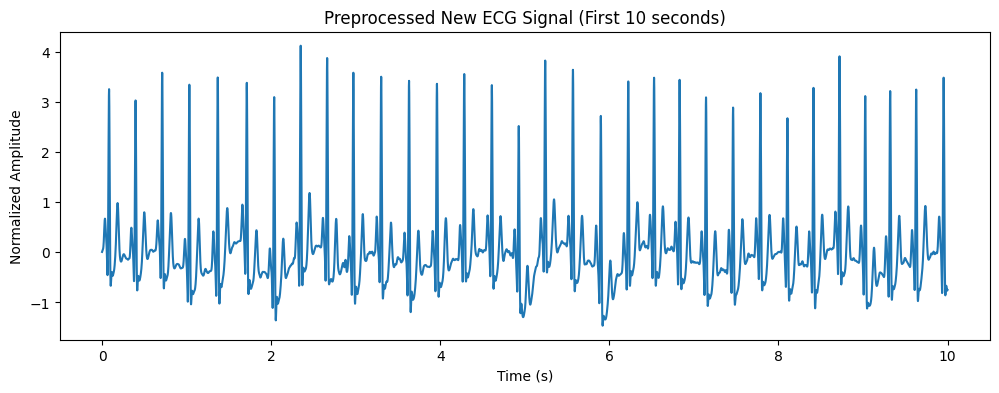

In [23]:
# Load a new ECG signal (example: another record from MIT-BIH)
# Load a new ECG signal (example: another record from MIT-BIH)
new_record_name =  record_dir + "101"  # Change this to the desired record
new_record = wfdb.rdrecord(new_record_name)
new_ecg_signal = new_record.p_signal[:, 0]  # Assuming single-channel ECG
fs = new_record.fs

# Example usage
fs = 1000  # Sampling frequency in Hz
time_axis = np.arange(0, len(ecg_signal)) / fs  # Time axis in seconds

# Apply bandpass filter
new_filtered_signal = bandpass_filter(new_ecg_signal, fs)
# Optionally smooth the signal
new_smoothed_signal = smooth_signal(new_filtered_signal, window_size=5)
new_normalized_signal = normalize_signal(new_smoothed_signal)


# Visualize the preprocessed signal
import matplotlib.pyplot as plt
time_axis = [i / fs for i in range(len(new_normalized_signal))]
plt.figure(figsize=(12, 4))
plt.plot(time_axis[:fs * 10], new_normalized_signal[:fs * 10])
plt.title("Preprocessed New ECG Signal (First 10 seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.show()



In [24]:


# Example usage
window_size = 100  # Fixed window size (e.g., 250 samples)
overlap = 50      # Overlap between windows (e.g., 50% overlap)

# Segment the normalized signal
new_segments = segment_signal(new_normalized_signal, window_size=window_size, overlap=overlap)

print(f"Extracted {len(new_segments)} segments with window size {window_size} and {overlap} samples overlap.")



Extracted 12999 segments with window size 100 and 50 samples overlap.


In [25]:
print(new_segments[0].shape)


(100,)


In [26]:
# Reshape segments for CNN+LSTM (adding a channel dimension)
new_segments_reshaped = new_segments.reshape(new_segments.shape[0], new_segments.shape[1], 1)

# Print the shape
print("Shape of input segments for model:", new_segments_reshaped.shape)


Shape of input segments for model: (12999, 100, 1)


In [27]:
# Predict using the trained model
predictions = model.predict(new_segments_reshaped)

# Convert predictions to binary labels (threshold at 0.5)
predicted_labels = (predictions > 0.5).astype(int)

# Print results
print("Predicted QRS presence for each segment:", predicted_labels.flatten())


407/407 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step
Predicted QRS presence for each segment: [1 1 0 ... 0 0 0]


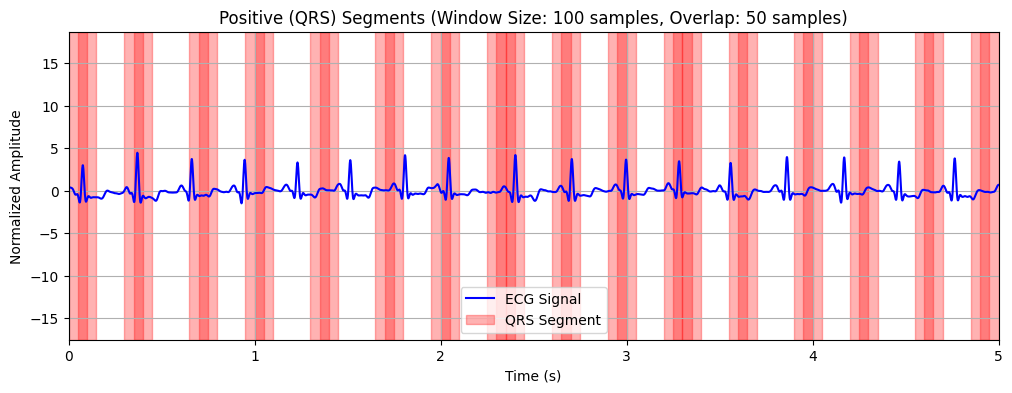

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


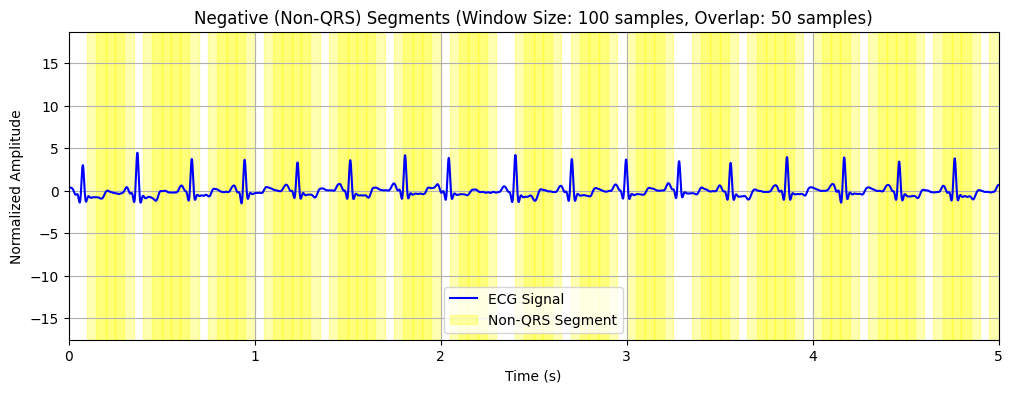

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Define fixed-length window parameters
window_size = 100  # Fixed window size (e.g., 250 samples)
overlap = 50      # Overlap between windows (e.g., 50% overlap)
half_window = window_size // 2  # Half window size

# Segment the signal into fixed-length windows
segmented_signal = new_segments

# Label the segments as QRS (1) or non-QRS (0)
segment_labels = predicted_labels


# Convert segment indices to start and end times (in seconds)
segment_windows = []
step = window_size - overlap  # Step size for sliding window
for i, start in enumerate(range(0, len(normalized_signal) - window_size + 1, step)):
    end = start + window_size
    segment_windows.append((start / fs, end / fs))  # Convert to seconds

# Separate positive (QRS) and negative (non-QRS) windows
positive_windows = [segment_windows[i] for i, label in enumerate(segment_labels) if label == 1]
negative_windows = [segment_windows[i] for i, label in enumerate(segment_labels) if label == 0]

# Define zoom window (e.g., from 0 to 5 seconds)
zoom_start = 0  # Start time in seconds
zoom_end = 5    # End time in seconds

# Plot 1: Positive (QRS) Segments
plt.figure(figsize=(12, 4))
plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

# Highlight positive (QRS) windows in red
for start, end in positive_windows:
    plt.axvspan(start, end, color="red", alpha=0.3, label="QRS Segment" if start == positive_windows[0][0] else "")

plt.title(f"Positive (QRS) Segments (Window Size: {window_size} samples, Overlap: {overlap} samples)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.xlim(zoom_start, zoom_end)  # Zoom in on the time range
plt.legend()
plt.grid()
plt.show()

# Plot 2: Negative (Non-QRS) Segments
plt.figure(figsize=(12, 4))
plt.plot(time_axis, normalized_signal, label="ECG Signal", color="blue")

# Highlight negative (non-QRS) windows in yellow
for start, end in negative_windows:
    plt.axvspan(start, end, color="yellow", alpha=0.3, label="Non-QRS Segment" if start == negative_windows[0][0] else "")

plt.title(f"Negative (Non-QRS) Segments (Window Size: {window_size} samples, Overlap: {overlap} samples)")
plt.xlabel("Time (s)")
plt.ylabel("Normalized Amplitude")
plt.xlim(zoom_start, zoom_end)  # Zoom in on the time range
plt.legend()
plt.grid()
plt.show()

